# 1. Sgr A* Flares Spectrum
__Some housekeeping__
* Run this notebook in Python 3.

The Sgr A* spectrum is given in figure 1. (Yuan et al. 2003)

![title](img/SpectrumYuan2003.PNG)


__Goals of this notebook__

* Create a seed distribution synchroton photons from a mildly relativistic electrons.
* Perform (at least one) IC scatterings.
* Put all of the machinery into the correct geometry, with the goal of reproducing the spectrum of flares in Sgr A* jets.


First we do some necessary python imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.integrate as integrate
from scipy.integrate import quad
from scipy.special import kv, gamma

Some constants

In [58]:
m_e=9.1*10**-28   # Electron mass [g]
e=5*10**-10       # Electron charge [esu]
k=1.4*10**-16     # Boltzmann constnat [erg/K]
c_light=3*10**10  # Speed of light [cm/s]
B=3               # Magnetic field [Gauss]
theta=np.pi/2     # Synchroton angle between velocity and field [rad]
h=10**-27         # Reduced planck constant [erg s]
sigma_t=6.65e-25  # Thomson cross section
theta_th=1           # Electron thermal energy in fractions of electron mass.

log_omega_min=5
log_omega_max=11

gamma_min=1
gamma_max=20


# Maxwell-Jüttner distribution of electrons
The velocity distribution of electrons that will produce the synchroton radiation is that of mildly relativistic electrons: $kT \sim m_e c^2$.
$$
        N(\gamma)=N_0\frac{\gamma^2\beta}{\theta K_2(1/\theta)}\text{exp}(-\frac{\gamma}{\theta}),
$$
    where $\theta = \frac{kT}{m_e c^2}$, and $K_2$ is the modified Bessel function of the second kind. 

Q: WHAT TO DO WITH $N_0$ (related to normalization)

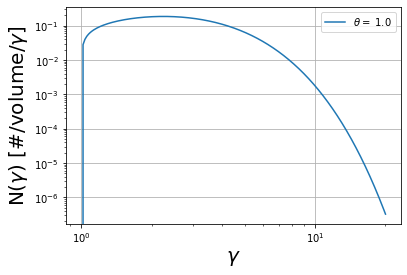

In [70]:
def MJ_of_gamma(gamma,theta_th):
    beta=np.sqrt(1-1/gamma**2)
    f=gamma**2*beta*np.exp(-gamma/theta_th)/(theta*kv(2,1./theta_th))
    return(f)
    
number=1000    
gamma = np.linspace(gamma_min,gamma_max,number)
MJ = np.zeros(number)

for i in range(len(gamma)):
    MJ[i] = MJ_of_gamma(gamma[i],theta_th)


plt.plot(gamma,MJ,label=r'$\theta=${:4.1f}'.format(theta_th))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\gamma$',fontsize=20)
plt.ylabel('N($\gamma$) [#/volume/$\gamma$]', fontsize=20)
plt.grid(1)
plt.legend()
plt.show()

Later on we will need function that will draw a random electron from the Maxwell-Jüttner distribution, we will do this now. The exact same process is used in the Monte Carlo tutorial, though I had to tweak it a bit.

In [155]:
def N_of_gamma(gamma):
        value=MJ_of_gamma(gamma,theta_th)
        return(value)

norm,error=quad(N_of_gamma,gamma_min,gamma_max) #normalization value, calculate this once, here. 
print('normalization factor is {0:5.3e}'.format(norm))

def N_electron_PDF(gamma):
    return(N_of_gamma(gamma)/norm)

normalization factor is 6.366e-01


Test if it works

surface under graph 1.000e+00


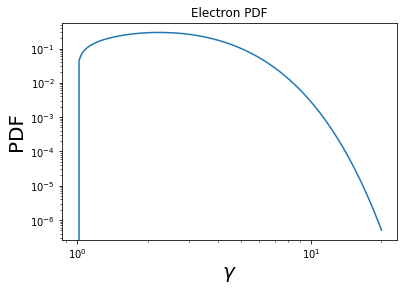

In [156]:
number=1000    
gamma = np.linspace(gamma_min,gamma_max,number)
P=np.zeros(number)

surface,error=quad(N_electron_PDF,gamma_min,gamma_max)
print('surface under graph {0:5.3e}'.format(surface))


for i in range(number):
    P[i]=N_electron_PDF(gamma[i])
   
plt.plot(gamma,P)
plt.title('Electron PDF')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\gamma$',fontsize=20)
plt.ylabel(r'PDF',fontsize=20)
plt.show()

Now we take this PDF and turn it into a CDF.

In [157]:
number = 100
def N_electron_CDF(gamma):
    integ=np.zeros(number)
    integ[0]=N_electron_PDF(gamma[0])
    for i in range(number-1):
        integ[i+1],error=quad(N_electron_PDF,gamma[i],gamma[i+1]) #integrate the PDF between every omega interval
    
    CDF=np.zeros(number)
    CDF[0]=integ[0]
    for i in range(number-1):
        CDF[i+1]=sum(integ[0:i+2]) # add up the intervals to create a CDF
    return(CDF)

Test if it works:

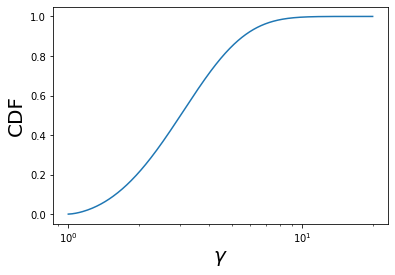

In [171]:
number=1000    
gamma = np.linspace(gamma_min,gamma_max,number)
CDF_electrons = N_electron_CDF(gamma) 


plt.plot(gamma,CDF_electrons)
plt.xscale('log')
plt.xlabel(r'$\gamma$',fontsize=20)
plt.ylabel(r'CDF',fontsize=20)
plt.show()

Then numerically invert:

In [172]:
def N_gamma_of_P(gamma,CDF,n_electrons):
    gamma_electron=np.interp(np.random.rand(n_electrons),CDF,gamma)
    return(gamma_electron)

And make a plot to see if it worked:

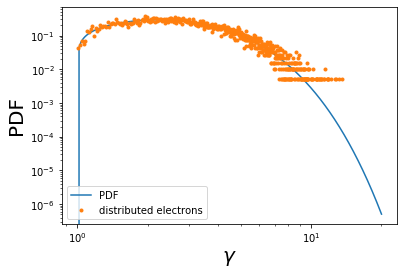

In [173]:
n_electrons=10000
number=1000    
gamma = np.linspace(gamma_min,gamma_max,number)
gamma_electron=N_gamma_of_P(gamma,CDF_electrons,n_electrons)
plot_bins=np.linspace(gamma_min,gamma_max,number)
electron_dist,edges=np.histogram(gamma_electron,bins=plot_bins,density=True)
plot_gammas=np.sqrt(plot_bins[1:]*plot_bins[:-1])
plt.plot(gamma,P,label='PDF')
plt.loglog(plot_gammas,electron_dist,'.',label='distributed electrons')
plt.xlabel('$\gamma$',fontsize=20)
plt.ylabel('PDF',fontsize=20)
plt.legend()
plt.show()



# Synchrotron power spectrum
The synchrotron power spectrum for a single electron is given by
$$
    P_{sync}(\omega)=\frac{\sqrt{3} e^3 B \sin{\theta}}{2\pi m_e c^2} F(x),
$$
where
$$
   F(x) = x \int_x^\infty K_{5/3}(\xi)d\xi,
$$
        and $x=\omega/\omega_c$. Also, $\omega_c=\frac{3}{2}\gamma^2\frac{eB}{m_e c}\sin{\theta}$. This implies that $\omega_c=\omega_c(\gamma)$ and thus that $F(x)=F(\gamma,\omega)$ and $P_{sync}(\omega)=P_{sync}(\gamma,\omega,\theta,B)$.
        
Next up, we make some functions that we will need to obtain the synchroton power spectrum as a function of magnetic field, lorentz factor and pitch angle.

In [76]:
def omega_c(gamma,B,theta):
    value=3/2*gamma**2*e*B/(m_e*c_light)*np.sin(theta)
    return(value)

def K_fivethird(x):
    value=kv(5/3,x)
    return(value)

def F_sync(omega,omega_c):
    x=omega/omega_c
    output_integral,error=quad(K_fivethird,x,np.inf)
    value=x*output_integral
    return(value)

def P_sync(gamma,omega,B,theta):
    value = np.sqrt(3)*e**3*B*np.sin(theta)/(2*np.pi*m_e*c**2)*F_sync(omega,omega_c(gamma,B,theta))
    return(value)




And we test the function out.

according to peak frequency formula, the peak should be at 2.473e+09 or 10^9.39


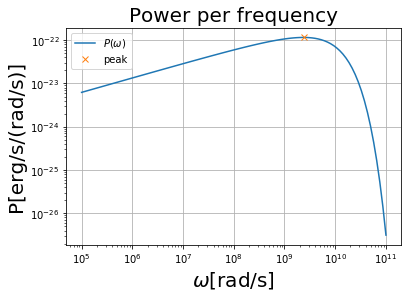

In [77]:
number = 100


omega = np.logspace(log_omega_min,log_omega_max,number)
P = np.zeros(number)

gamma = 10


for i in range(number):
    P[i] = P_sync(gamma,omega[i],B,theta)

omega_peak=0.3*omega_c(gamma,B,theta)
print('according to peak frequency formula, the peak should be at {0:5.3e} or 10^{1:3.2f}'.format(omega_peak,np.log10(omega_peak)))

plt.plot(omega,P, label='$P(\omega)$')
plt.plot(omega_peak,P_sync(gamma,omega_peak,B,theta),'x', label='peak')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title(r'Power per frequency',fontsize=20)
plt.xlabel(r'$\omega$[rad/s]',fontsize=20)
plt.ylabel(r'P[erg/s/(rad/s)]',fontsize=20)
plt.grid(1)
plt.show()


plt.show()

Now we want to combine the velocity distribution and power spectrum into a total spectrum, by 

$$
    P_{tot}(\omega)= \int P_{sync}(\gamma, \omega) N(\gamma) d\gamma
$$

In [78]:
def P_tot(gamma_min,gamma_max,omega,B,theta):
    def P_of_gamma(gamma):                            #integration only takes single variable functions
        value=P_sync(gamma,omega,B,theta)
        return(value)
    def N_of_gamma(gamma):                            #integration only takes single variable functions
        value=MJ_of_gamma(gamma,theta_th)
        return(value)
    def integrand(gamma):
        value=N_of_gamma(gamma)*P_of_gamma(gamma)
        return(value)
    output,error=quad(integrand,gamma_min,gamma_max)
    value=output
    return(output)
            

Try it out

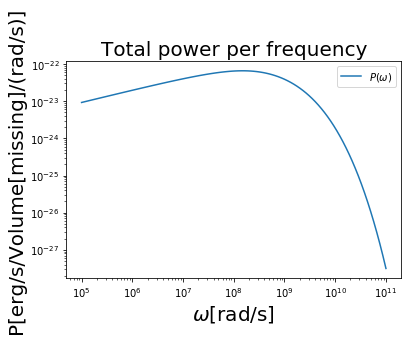

In [79]:
number=100
omega=np.logspace(log_omega_min,log_omega_max,number)


P=np.zeros(number)

for i in range(number):
    P[i]=P_tot(gamma_min,gamma_max,omega[i],B,theta)

plt.plot(omega,P, label='$P(\omega)$')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title(r'Total power per frequency',fontsize=20)
plt.xlabel(r'$\omega$[rad/s]',fontsize=20)
plt.ylabel(r'P[erg/s/Volume[missing]/(rad/s)]',fontsize=20)
plt.show()



# The seed photon distribution
We now want to be able to use this result to create some seed photons, according to the above distribution. To do this, we have to create a function that will return a random photon according to the above distribution. I will first make a PDF, and use it to make a cumulative PDF. 

In [198]:
def N_of_omega(omega):
        value=P_tot(gamma_min,gamma_max,omega,B,theta)/(h*omega) #NUMBER OF PHOTONS
        return(value)

norm,error=quad(N_of_omega,10**log_omega_min,10**log_omega_max) #normalization value, calculate this once, here. 
print('normalization factor is {0:5.3e}'.format(norm))

def N_photon_PDF(omega):
    return(N_of_omega(omega)/norm)

normalization factor is 3.930e+05


Now test if it works.

surface under graph 1.000e+00


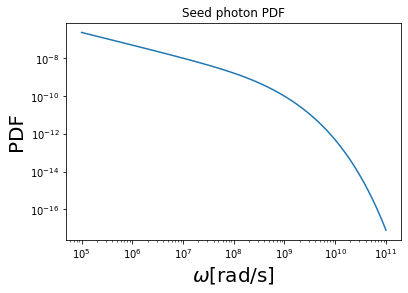

In [199]:
number=100
omega=np.logspace(log_omega_min,log_omega_max,number)
P=np.zeros(number)

surface,error=quad(N_photon_PDF,10**log_omega_min,10**log_omega_max)
print('surface under graph {0:5.3e}'.format(surface))


for i in range(number):
    P[i]=N_photon_PDF(omega[i])
   
plt.plot(omega,P)
plt.title('Seed photon PDF')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\omega$[rad/s]',fontsize=20)
plt.ylabel(r'PDF',fontsize=20)
plt.show()

Then we take this PDF and turn it into a CDF.

In [200]:
number=100
def N_photon_CDF(omega):
    integ=np.zeros(number)
    integ[0]=N_photon_PDF(omega[0])
    for i in range(number-1):
        integ[i+1],error=quad(N_photon_PDF,omega[i],omega[i+1]) #integrate the PDF between every omega interval
    
    CDF=np.zeros(number)
    CDF[0]=integ[0]
    for i in range(number-1):
        CDF[i+1]=sum(integ[0:i+2]) # add up the intervals to create a CDF
    return(CDF)

Make a quick plot: (ok. it's not that quick.)

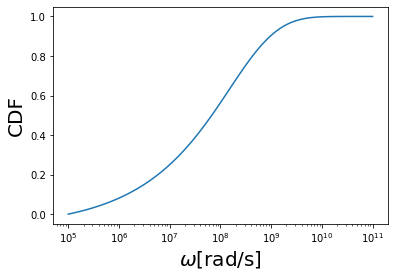

In [202]:
number = 100
omega=np.logspace(log_omega_min,log_omega_max,number)
CDF_photons = N_photon_CDF(omega) 


plt.plot(omega,CDF_photons)
plt.xscale('log')
plt.xlabel(r'$\omega$[rad/s]',fontsize=20)
plt.ylabel(r'CDF',fontsize=20)
plt.show()

Next up we want to invert the CDF and create a function  𝜔(𝑃) , where  𝑃  is a random variable. Many photons drawn using  𝜔(𝑃)  are then distributed with an  𝜔  according to the PDF.

In [203]:
def N_omega_of_P(omega, CDF,n_photons):
    e_phot=np.interp(np.random.rand(n_photons),CDF,omega)
    return(e_phot)

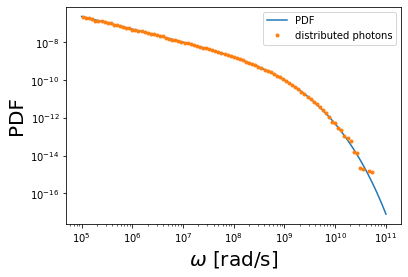

In [204]:
n_photons=100000
photons=np.zeros(n_photons)
number=100
omega=np.logspace(log_omega_min,log_omega_max,number)
omega_phot=N_omega_of_P(omega,CDF_photons,n_photons)
plot_bins=np.logspace(log_omega_min,log_omega_max,number)
photon_dist,edges=np.histogram(omega_phot,bins=plot_bins,density=True)
plot_omegas=np.sqrt(plot_bins[1:]*plot_bins[:-1])
plt.plot(omega,P,label='PDF')
plt.loglog(plot_omegas,photon_dist,'.',label='distributed photons')
plt.xlabel('$\omega$ [rad/s]',fontsize=20)
plt.ylabel('PDF',fontsize=20)
plt.legend()
plt.show()

# Import some stuff from the Monte Carlo tutorial!
Define mc_parms: 

In [86]:
def f_of_v_mono():                    # we will define this later
    return(0)
def f_of_hnu_mono():                  # we will define this later
    return(0)

mc_parms={'n_photons':100000,         # number of trials--start somewhat small and go up
          'kt_seeds':1.6e-9,          # temperature/energy of the seed photons (in energy units)
          'H':3e7,                    # height of the corona (H ~ R, and R ~ 100 R_g ~ 3e7 cm)
          'velocity':3e9,             # electron velocity (only used by mono-energetic distribution)
          'kt_electron':3.2e-8,       # electron temperature (in energy units, used by Maxwellian)
          'tau':0.1,                  # optical depth of the corona
          'v_dist':f_of_v_mono,      # name of velocity distribution function (start with delta function)
          'hnu_dist':f_of_hnu_mono,  # name of photon distribution function (start with delta function)
         }

Define compton_y function

In [87]:
def compton_y(pre,post):
    return(np.mean((post-pre)/pre))

def test_compton_y():
    post=np.ones(100)*2
    pre=np.ones(100)
    print('Your code produces a y-parameter of {:5.2f}. The test value of 1.00'.format(compton_y(pre,post)))
    
test_compton_y()

Your code produces a y-parameter of  1.00. The test value of 1.00


Define random_direction function

In [88]:
def random_direction(number=None):
    """Returns randomly oriented unit vectors.

    Args: 
        None
        
    Parameters:
        number: number of random vectors to return

    Returns::
        (number,3)-element numpy array: Randomly oriented unit vectors
    """

    #
    # This is how you draw a random number for a uniform
    # distribution:
    #

    if number is None:
        number=1

    phi=2.*np.pi*np.random.rand(number)
    cos_phi=np.cos(phi)
    sin_phi=np.sin(phi)
    cos_theta=2.*np.random.rand(number)-1
    sin_theta=np.sqrt(1 - cos_theta**2)
    return((np.array([sin_theta*cos_phi,sin_theta*sin_phi,cos_theta])).transpose())

Define f_of_hnu_mono

In [89]:
def f_of_hnu_mono(mc_parms,number=None):
    """Returns randomly drawn velocity from distribution function
    
    Args:
        mc_parms (dictionary): Monte-Carlo parameters
    
    Parameters:
        number (integer): Number of photon energies to generate

    Returns:
        numpy array: seed photon energies drawn from photon distribution
    """
    if number is None:
        number=1
    return(np.ones(number)*mc_parms['kt_seeds'])

Define photon_origin

In [90]:
def photon_origin(number=None):
    """Returns emission location of a photon
    """
    if number is None:
        number=1
    return(np.zeros([number,3]))

Define draw_seed_photons

In [91]:
def draw_seed_photons(mc_parms,number=None):
    """Returns a single seed photon
    
    Args:
        mc_parms (dictionary): MC parameters
    
    Parameters:
        number (integer): number of photons to return
        
    Returns:
        (number x 4)numpy array: Photon momentum 4-vectors
        (number x 3)numpy array: Initial photon positions
    """

    if number is None:
        number=1
    x_seed=photon_origin(number=number)
    n_seed=random_direction(number=number)
    hnu=mc_parms['hnu_dist'](mc_parms,number=number)
    p_seed=(np.array([hnu,hnu*n_seed[:,0],hnu*n_seed[:,1],hnu*np.abs(n_seed[:,2])])).transpose()/c_light
    return(p_seed,x_seed)

Define tau_of_scatter

In [92]:
def tau_of_scatter():
    """Calculates optical depth a photon traveled to before interacting, given probability
    
    Args:
        None
        
    Returns:
        real: Optical depth as function of P

    """
    
    # First, draw your random probability P
    tau=-np.log(np.random.rand())
    return(tau)

Define distance_of_scatter

In [93]:
def distance_of_scatter(mc_parms):
    """Calculates the distance that corresponds to an optical depth tau   

    Args:
        tau (real): optical depth photon travels before scattering occurs
        mc_parsm (dictionary): MC parameters

    Returns:
        real: distance

    """

    tau=tau_of_scatter()
    electron_density=mc_parms['tau']/mc_parms['H']/sigma_t
    distance=tau/sigma_t/electron_density
    
    return(distance)

Define scatter_location:

In [94]:
def scatter_location(x_old,p_photon,mc_parms):
    """This function goes through the steps of a single scattering

    Args:
        x_old.   (three-element numpy array): holds the position
        p_photon (four-element numpy array): the in-coming photon four-momentum
        mc_parms (dictionary): the simulation parameters
    
    Returns:
        three-element numpy array: scattering location
    """
    
    # ...path-length:
    distance = distance_of_scatter(mc_parms)
    
    # ...in direction:
    photon_direction=p_photon[1:]/p_photon[0]
    
    # Update photon position with the new location
    x_new = x_old + distance*photon_direction
    
    return(x_new)

Define f_of_v_mono

In [95]:
def f_of_v_mono(mc_parms):
    """Returns a single randomly drawn velocity from distribution function
    
    Args:
        mc_parms (dictionary): Monte-Carlo parameters

    Returns:
        real: electron velocity drawn from distribution
    """
    
    return(mc_parms['velocity'])

Drawing random electron velocities

In [96]:
def draw_electron_velocity(mc_parms,p_photon):
    """Returns a randomized electron velocity vector for inverse 
       Compton scattering, taking relativistic foreshortening of the
       photon flux in the electron frame into account
       
       Args:
           mc_parms (dictionary): Monte-Carlo parameters
           p_photon (4 dimentional np array): Photon 4-momentum
           
       Returns:
           3-element numpy array: electron velocity
    """
    v=mc_parms['v_dist'](mc_parms)
    n=draw_electron_direction(v,p_photon)
    return(v*n)

def draw_electron_direction(v,p_photon):
    """Draw a randomized electron direction, taking account of the
       increase in photons flux from the foward direction, which
       effectively increases the cross section for forward scattering.
       
       Args:
            v (real): electron speed
            p_photon (4 element numpy array): photon 4-momentum
            
       Returns:
           3-element numpy array: randomized electron velocity vector
    """
    phi=2.*np.pi*np.random.rand()
    cosp=np.cos(phi)
    sinp=np.sin(phi)
    cost=mu_of_p_electron(v/c_light,np.random.rand())
    sint=np.sqrt(1 - cost**2)
    
    n_1=p_photon[1:]/p_photon[0]
    if (np.sum(np.abs(n_1[1:2])) != 0):
        n_2=np.cross(n_1,np.array([1,0,0]))
    else:
        n_2=np.cross(n_1,np.array([0,1,0]))
    n_2/=np.sqrt(np.sum(n_2**2))
    n_3=np.cross(n_1,n_2)
    
    # express new vector in old base
    n_new=(n_2*cosp+n_3*sinp)*sint + n_1*cost
    return(n_new/np.sqrt(np.sum(n_new**2)))

def mu_of_p_electron(beta,p):
    """Invert probability for foreshortened effective
       Thomson scattering cross section, with
    
       P = 
       
       Args:
           beta (real): v/c for electron
           p: probability value between 0 and 1
           
       Returns:
           real: cos(theta) relative to photon direction
    """
    mu=1/beta-np.sqrt(1/beta**2 + 1 - 4*p/beta + 2/beta)
    return(mu)

Lorentz Transform

In [97]:
def lorentz_transform(p,v):
    """Returns general Lorentz transform

    Args:
        p (four-element numpy array): input four-vector
        v (three-element numpy array): the 3-velocity of the frame we want to transform into

    Returns:
        four-element numpy array: the transformed four-vector
    """

    beta=np.sqrt(np.sum(v**2))/c_light
    beta_vec=v/c_light
    gamma=1./np.sqrt(1. - beta**2)
    matrix=np.zeros((4,4))
    matrix[0,0]=gamma
    matrix[1:,0]=-gamma*beta_vec
    matrix[0,1:]=-gamma*beta_vec
    matrix[1:,1:]=(gamma-1)*np.outer(beta_vec,beta_vec)/beta**2
    for i in range(1,4):
        matrix[i,i]+=1
    return(np.dot(matrix,p))

Scattering angle

In [98]:
def cos_theta_thomson(p):
    """Invert P(<\theta) to calculate cos(theta)
        
        Args:
            p (real): probability between 0 and 1
            
        Returns:
            real: scattering angle drawn from Thomson distribution
    """
    a=-4 + 8*p
    b=a**2 + 4
    return((np.power(2,1/3)*np.power(np.sqrt(b)-a,2/3)-2)/
           (np.power(2,2/3)*np.power(np.sqrt(b)-a,1/3)))


Thomson scattering machinery

In [99]:
def thomson_scatter(p_photon):
    """This function performs Thomson scattering on a photon
    
    Args:
        p_photon (4-element numpy array): Incoming photon four-vector
        
    Returns:
        4-element numpy array: Scattered photon four-vector
    """
    
    n_1=p_photon[1:]/p_photon[0]
    if (np.sum(np.abs(n_1[1:2])) != 0):
        n_2=np.cross(n_1,np.array([1,0,0]))
    else:
        n_2=np.cross(n_1,np.array([0,1,0]))
    n_2/=np.sqrt(np.sum(n_2**2))
    n_3=np.cross(n_1,n_2)

    # scattering is uniform in phi
    phi=2.*np.pi*np.random.rand()
    cosp=np.cos(phi)
    sinp=np.sin(phi)
    
    # draw cos_theta from proper distribution
    cost=cos_theta_thomson(np.random.rand())
    sint=np.sqrt(1 - cost**2)
    
    # express new vector in old base
    n_new=(n_2*cosp+n_3*sinp)*sint + n_1*cost
    n_new/=np.sqrt(np.sum(n_new**2))
    
    # return scatterd 4-momentum vector
    return(np.array(p_photon[0]*np.array([1,n_new[0],n_new[1],n_new[2]])))

Inverse thomson scatter

In [100]:
def inverse_compton_scatter(p_photon,mc_parms):
    """This function performs an iteration of inverse Compton scattering off an electron of velocity v_vec.
    
    Args:
        p_photon (four element numpy array): input photon four-momentum
        v_vec (three element numpy array): 3-velocity vector of the scattering electron
        
    Returns:
        four-element numpy array: scattered photon four-momentum in observer's frame
    """
    
    # throw the dice one more time to draw a random electron velocity
    velocity=draw_electron_velocity(mc_parms,p_photon)
    # first, transform to electron frame
    p_photon_prime=lorentz_transform(p_photon,velocity)

    # Thomson scatter
    p_out_prime=thomson_scatter(p_photon_prime)
    
    # transform back to observer frame
    return(lorentz_transform(p_out_prime,-velocity))

Monte Carlo

In [101]:
def monte_carlo(mc_parms):
    """Perform a simple Monte-Carlo simulation

    Args:
       mc_parms (dictionary): Monte-Calro parameters
    
    Returns:
        numpy array: List of escaped photon energies
        numpy array: Lost of seed energies of all escaping photons
    """
    
    # arrays to store initial and final photon energies
    hnu_seed=np.zeros(mc_parms['n_photons'])
    hnu_scattered=hnu_seed.copy()

    # draw our seed-photon population. Much faster to do this once for all photons
    p_photons,x_photons=draw_seed_photons(mc_parms,number=mc_parms['n_photons'])
   
    # run the scattering code n_photons times
    for p_photon,x_photon,i in zip(p_photons,x_photons,range(mc_parms['n_photons'])):
        # initial photon four-momentum
        # store seed photon energy for future use (calculating Compton-y parameter)
        hnu_seed[i]=p_photon[0]*c_light

        # keep scattering until absorbed or escaped
        scattered=True
        while (scattered):
            # find next scattering location
            x_photon = scatter_location(x_photon,p_photon,mc_parms)
            # if it's inside the corona, perform inverse Compton scatter
            if (x_photon[2]>=0 and x_photon[2]<=mc_parms['H']):
                p_photon=inverse_compton_scatter(p_photon,mc_parms)
            else:
                scattered=False
                if (x_photon[2]<=0):
                    p_photon*=0

        # store the outgoing photon energy in the array
        hnu_scattered[i]=p_photon[0]*c_light

    # only return escaped photons and their seed energy
    return(hnu_scattered[hnu_scattered > 0],hnu_seed[hnu_scattered > 0])

def monte_carlo_2(mc_parms):
    """Perform a simple Monte-Carlo simulation

    Args:
       mc_parms (dictionary): Monte-Calro parameters
    
    Returns:
        numpy array: List of escaped photon energies
        numpy array: Lost of seed energies of all escaping photons
    """
    
    # arrays to store initial and final photon energies
    hnu_seed=np.zeros(mc_parms['n_photons'])
    hnu_scattered=hnu_seed.copy()

    # draw our seed-photon population. Much faster to do this once for all photons
    p_photons,x_photons=draw_seed_photons(mc_parms,number=mc_parms['n_photons'])
   
    # run the scattering code n_photons times
    for p_photon,x_photon,i in zip(p_photons,x_photons,range(mc_parms['n_photons'])):
        # initial photon four-momentum
        # store seed photon energy for future use (calculating Compton-y parameter)
        hnu_seed[i]=p_photon[0]*c_light

        # keep scattering until absorbed or escaped
        p_photon=inverse_compton_scatter(p_photon,mc_parms)
        hnu_scattered[i]=p_photon[0]*c_light

    # only return escaped photons and their seed energy
    return(hnu_scattered[hnu_scattered > 0],hnu_seed[hnu_scattered > 0])

Wrapper

In [102]:
def plot_mc(mc_parms,bins=None,xlims=None):
    """Run an MC simulation and plot a histogram of the output. DOES NOT SAVE A PDF :)
    
    Args:
        mc_parms (dictionary): Monte-Carlo parameters
    
    Paramters:
        bins (numpy array): Optional spectral bins
        xlims (2-element list, real): plot-limits
    
    Returns:
        numpy array: The energies of all photons escaping the corona
        numpy array: The seed-energies of the escaping photons
    """
    
    
    
    # Now run simulation and normalize all outgoing photon energies 
    # so we can investigate energy gains and losses
    hnu_scattered,hnu_seeds=np.array(monte_carlo(mc_parms))/mc_parms['kt_seeds'] 
    
    if (xlims is None):
        xlims=[hnu_scattered.min(),hnu_scattered.max()]    
    if (bins is None):
        bins=np.logspace(np.log10(xlims[0]),np.log10(xlims[1]),num=100)
    else:
        bins=np.logspace(np.log10(xlims[0]),np.log10(xlims[1]),num=bins)
   

    fig=plt.figure()
    plt.hist(hnu_scattered,bins=bins,log=True,
             label=r'$\tau=${:4.1f}'.format(mc_parms['tau']))
    plt.xscale('log')
    plt.xlim(xlims[0],xlims[1])
    plt.xlabel(r'$h\nu/h\nu_{0}$',fontsize=20)
    plt.ylabel(r'$N(h\nu)$',fontsize=20)
    plt.legend()
    plt.show()
    print('Fraction of escaping photons: {0:5.3e}\n'.format(hnu_scattered.size/mc_parms['n_photons']))
    print('Compton y parameter: {0:5.3e}\n'.format(compton_y(hnu_seeds,hnu_scattered)))
    return(hnu_scattered,hnu_seeds)

Quick test

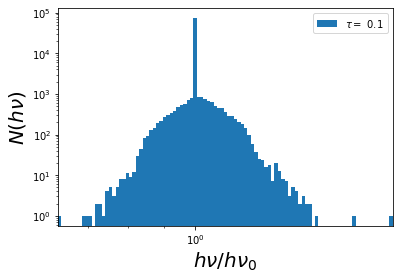

Fraction of escaping photons: 8.576e-01

Compton y parameter: 2.381e-03



In [103]:
mc_parms={'n_photons':100000,         # start somewhat small and go up
          'kt_seeds':1.6e-9,         # 1 keV input photons
          'H':1e7,                   # say H ~ R, and R ~ 100 R_g ~ 3e7 cm
          'velocity':3e9,            # 10% speed of light--pretty hot
          'tau':0.1,                 # tau ~ 0.1: Small-ish optical depth
          'v_dist':f_of_v_mono,      # name of velocity distribution function
          'hnu_dist':f_of_hnu_mono,  # name of photon distribution function
         }

hnu_scattered,hnu_seeds=plot_mc(mc_parms,bins=100)

# The electron distribution function
Before, we've already created a function that spawns a random electron according to the Maxwell-Jüttner distribution. We will now tweak it so that it can be used as a velocity distribution function in the Monte Carlo simulation.

In [224]:
# since theta_th = 1, we must have
mc_parms['kt_electron']=theta_th*8.2e-7 # 1 electron mass in [erg]



def f_of_v_MJ(mc_parms):
    number=1000
    n_electrons=1
    gamma = np.linspace(gamma_min,gamma_max,number)
    gamma_electron=N_gamma_of_P(gamma,CDF_electrons,n_electrons)
    v=np.sqrt(1-1/gamma_electron**2)*c_light
    return(v)
    

# The photon distribution function

In [225]:
def f_of_hnu_sync(mc_parms,number=None):
    if number is None:
        number=1
    omega=np.logspace(log_omega_min,log_omega_max,100)
    omega = N_omega_of_P(omega,CDF_photons,number)
    hnu=h*omega
    return(hnu)

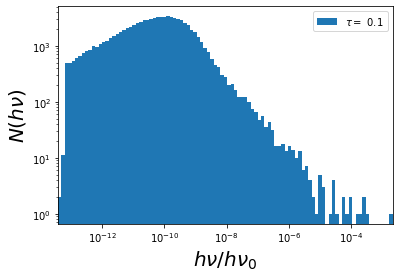

Fraction of escaping photons: 8.442e-01

Compton y parameter: 3.086e+03



In [226]:
mc_parms={'n_photons':100000,         # start somewhat small and go up
          'kt_seeds':1.6e-9,         # 1 keV input photons
          'H':1e7,                   # say H ~ R, and R ~ 100 R_g ~ 3e7 cm
          'velocity':3e9,            # 10% speed of light--pretty hot
          'tau':0.1,                 # tau ~ 0.1: Small-ish optical depth
          'v_dist':f_of_v_MJ,      # name of velocity distribution function
          'hnu_dist':f_of_hnu_sync,  # name of photon distribution function
         }

hnu_scattered,hnu_seeds=plot_mc(mc_parms,bins=100)